- reference: https://www.kaggle.com/sahil112/whyonlykeras-easy-pytorch-competitive-dnn

# Point to take care of now onwards
1. Add PCA components
2. Search how to make the NN deeper
3. Get it on the GPU
4. Plot training losses with the validation losses
5. use K-fold CV

# Import

In [1]:
import os
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
from scipy import stats

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Load Dataset

In [3]:
n_features = 300
features = [f"f_{i}" for i in range(n_features)]
train = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')

In [4]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


In [6]:
inputs = train.drop(['row_id', 'target'], axis = 1).values
targets = train[['target']].values

In [7]:
print(f"inputs shape: {inputs.shape}")
print(f"targets shape: {targets.shape}")

inputs shape: (3141410, 302)
targets shape: (3141410, 1)


In [8]:
# split 80% split
val_1 = int(0.8*inputs.shape[0])
val_2 = int(inputs.shape[0] - val_1)

print(f"80% split data train#: {val_1}, val#: {val_2}")

80% split data train#: 2513128, val#: 628282


In [9]:
# Hyperparameters setting
batch_size = 2048
TARGET_COLUMN = "target"

input_size = 302
output_size = 1

In [10]:
# gc
del train
gc.collect()

105

# Convert to PyTorch Dataset (DataLoader)

In [11]:
dataset = TensorDataset(torch.tensor(inputs, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32))
train_ds, val_ds = random_split(dataset, [val_1, val_2])

train_loader = DataLoader(train_ds, batch_size, shuffle = False)
val_loader = DataLoader(val_ds, batch_size * 2)

In [12]:
del train_ds, val_ds, dataset, inputs, targets
gc.collect()

42

# GPU Utilities
> these will help later to get our models/dataloaders on the GPU!

In [13]:
def get_default_device():
    """
        Pick GPU if available, else CPU
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """
        Move tensor to chosen device
    """
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [14]:
class DeviceDataLoader():
    """
        Wrap a dataloader to move data to a device
    """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """
            Yield a batch of data after moving it to device
        """
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        """
            Number of batches
        """
        return len(self.dl)

In [15]:
# Check if GPU is avaliable
torch.cuda.is_available()

True

In [16]:
device = get_default_device()
print(device)

cuda


### Push to the GPU

In [17]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

# This is the heart of the Neural Network

In [18]:
class My_Kaggle_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, 256),
                                    nn.BatchNorm1d(256),
                                    nn.SiLU(),
                                    
                                    nn.Linear(256, 128),
                                    nn.BatchNorm1d(128),
                                    nn.SiLU(), # nn.LeakyReLU(0.1)
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(128, 64),
                                    nn.BatchNorm1d(64),
                                    nn.SiLU(), # nn.LeakyReLU(0.1)
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(64, 32),
                                    nn.BatchNorm1d(32),
                                    nn.SiLU(), # nn.LeakyReLU(0.1)
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(32, 16),
                                    nn.BatchNorm1d(16),
                                    nn.SiLU(), # nn.LeakyReLU(0.1)
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(16, 8),
                                    nn.BatchNorm1d(8),
                                    nn.SiLU(), # nn.LeakyReLU(0.1)
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(8, 1)
                                   )
        
    def forward(self, x):
        return self.layers(x)
    
    def training_step(self, batch):
        torch.cuda.empty_cache()
        inputs, targets = batch
        inputs.to(device)
        targets.to(device)
        
        output = self(inputs)
        loss = F.mse_loss(output, targets)
        return loss
    
    def validation_step(self, batch):
        torch.cuda.empty_cache()
        inputs, targets = batch
        inputs.to(device)
        targets.to(device)
        
        output = self(inputs)
        loss = F.mse_loss(output, targets)
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))
        
model = My_Kaggle_Model()

In [19]:
# shift model to GPU
model = to_device(model, device)

### Simple functions for evaluating and fitting

In [20]:
def evaluate(model, val_loader):
    # Setting to "eval mode"
    # make sure that dropouts are "frozen"
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [21]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Train Phase
        # Setting to "train mode"
        model.train()
        train_losses = []
        
        for (i, batch) in enumerate(train_loader):
            torch.cuda.empty_cache()
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if (i%200 == 0):
                print(f"batch number -- {i}")
                
        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
        # Early Stopping
        ####
        
    return history

In [22]:
# Checking if everthing is on the GPU
print(train_loader.device)
print(val_loader.device)

print(type(model))

cuda
cuda
<class '__main__.My_Kaggle_Model'>


In [23]:
model.state_dict()['layers.0.weight']

tensor([[-0.0466, -0.0071,  0.0550,  ..., -0.0531, -0.0016,  0.0285],
        [ 0.0484,  0.0468,  0.0426,  ..., -0.0418, -0.0531, -0.0438],
        [ 0.0390, -0.0383,  0.0335,  ...,  0.0368, -0.0198, -0.0019],
        ...,
        [-0.0471, -0.0073, -0.0520,  ...,  0.0369,  0.0488, -0.0115],
        [ 0.0482,  0.0486,  0.0439,  ...,  0.0558,  0.0552,  0.0280],
        [ 0.0153, -0.0389, -0.0099,  ..., -0.0267,  0.0238, -0.0293]],
       device='cuda:0')

# Train

In [24]:
learning_rate = 1e-1

In [25]:
history = fit(10, learning_rate, model, train_loader, val_loader, opt_func = torch.optim.Adam)

batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [0], train_loss: 0.8468, val_loss: 0.8480
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [1], train_loss: 0.8463, val_loss: 0.8507
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [2], train_loss: 0.8464, val_loss: 0.8480
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [3], train_loss: 0.8463, val_loss: 0.8514
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [4], train_loss: 0.8464, val_loss: 0.8509
batch number -- 0
batch number -- 200
batch number -- 400
ba

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No. of epochs')

In [27]:
# train for more with lower learning rate
history2 = fit(10, 5e-3, model, train_loader, val_loader, opt_func = torch.optim.Adam)

batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [0], train_loss: 0.8456, val_loss: 0.8482
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [1], train_loss: 0.8456, val_loss: 0.8482
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [2], train_loss: 0.8456, val_loss: 0.8481
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [3], train_loss: 0.8456, val_loss: 0.8481
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [4], train_loss: 0.8456, val_loss: 0.8482
batch number -- 0
batch number -- 200
batch number -- 400
ba

In [28]:
# train for more with lower learning rate
history3 = fit(10, 5e-5, model, train_loader, val_loader, opt_func = torch.optim.Adam)

batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [0], train_loss: 0.8456, val_loss: 0.8478
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [1], train_loss: 0.8455, val_loss: 0.8478
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [2], train_loss: 0.8455, val_loss: 0.8478
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [3], train_loss: 0.8455, val_loss: 0.8478
batch number -- 0
batch number -- 200
batch number -- 400
batch number -- 600
batch number -- 800
batch number -- 1000
batch number -- 1200
Epoch [4], train_loss: 0.8455, val_loss: 0.8478
batch number -- 0
batch number -- 200
batch number -- 400
ba

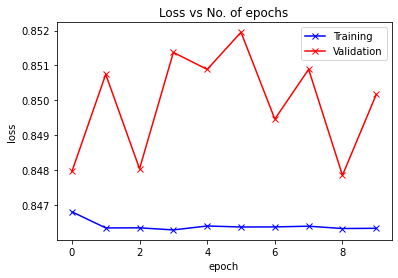

In [29]:
plot_losses(history)

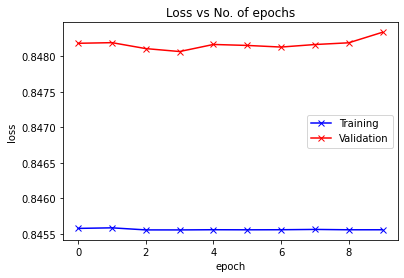

In [30]:
plot_losses(history2)

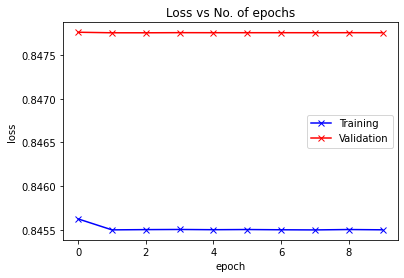

In [31]:
plot_losses(history3)